In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
import pandas as pd
import os
import shutil
import zipfile

Root_dir = '/content'
Data_dir = os.path.join(Root_dir,'driving')

if os.path.exists(Data_dir):
  shutil.rmtree(Data_dir)

with zipfile.ZipFile(os.path.join(Root_dir,'driving.zip'),'r') as file:
  file.extractall(Data_dir)

train_data = pd.read_csv(os.path.join(Data_dir,'train_motion_data.csv'))
test_data = pd.read_csv(os.path.join(Data_dir,'test_motion_data.csv'))
data = pd.concat([train_data,test_data],ignore_index=True)

In [ ]:
drop_columns = ['Timestamp']
# data = data.drop(drop_columns,axis='columns')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6728 entries, 0 to 6727
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AccX       6728 non-null   float64
 1   AccY       6728 non-null   float64
 2   AccZ       6728 non-null   float64
 3   GyroX      6728 non-null   float64
 4   GyroY      6728 non-null   float64
 5   GyroZ      6728 non-null   float64
 6   Class      6728 non-null   object 
 7   Timestamp  6728 non-null   int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 420.6+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6728 entries, 0 to 6727
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       6728 non-null   float64
 1   1       6728 non-null   float64
 2   2       6728 non-null   float64
 3   3       6728 non-null   float64
 4   4       6728 non-null   float64
 5   5       6728 non-null   float64
 6   6       6728 non-null   float64
 7   7       6728 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 420.6 KB
None


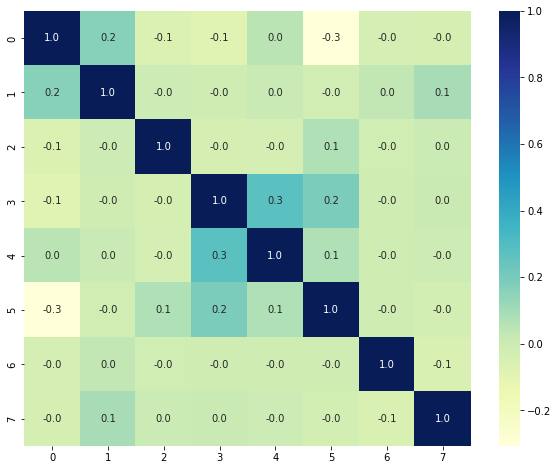

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns


x = data.drop('Class',axis='columns')
y = data['Class']

scaler = MinMaxScaler()
label = LabelEncoder()
x = scaler.fit_transform(x)
y = label.fit_transform(y)

# class_name = {}
# class_count = y.unique()
# for i,c in enumerate(class_count):
#   class_name[c] = i
# keys = class_name.keys()
# values = class_name.values()
# print(class_name)

# y = y.replace(keys,values)
# print(y)

corr = pd.concat([pd.DataFrame(x),pd.DataFrame(y)],axis=1,ignore_index=True)
print(corr.info())
plt.figure(figsize = (10,8))
sns.heatmap(corr.corr(),annot=True,fmt='.1f',cmap='YlGnBu')

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=789)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier



Models = ['AdaBoost','ExtraTrees','GradientBoosting','RandomForest','HistGradientBoosting','GaussianProcessClassifier','RidgeClassifier',
          'KNeighborsClassifier','RadiusNeighborsClassifier','DecisionTreeClassifier','ExtraTreeClassifier']

Regressors = {'AdaBoost' : AdaBoostClassifier(),
'ExtraTrees' : ExtraTreesClassifier(),
'GradientBoosting' : GradientBoostingClassifier(),
'RandomForest' : RandomForestClassifier(),
'HistGradientBoosting' : HistGradientBoostingClassifier(),
'GaussianProcessClassifier' : GaussianProcessClassifier(),
'RidgeClassifier' : RidgeClassifier(),
'KNeighborsClassifier' : KNeighborsClassifier(n_neighbors = 3),
'RadiusNeighborsClassifier' : RadiusNeighborsClassifier(),
'DecisionTreeClassifier' : DecisionTreeClassifier(),
'ExtraTreeClassifier' : ExtraTreeClassifier()}

In [ ]:
from sklearn.metrics import accuracy_score

res = pd.DataFrame(columns=['model','train_acc','test_acc'])
feature_importance = pd.DataFrame()

for i in Models:
  name = i
  model = Regressors[i]

  model.fit(x_train,y_train)

  train_acc = accuracy_score(y_train,model.predict(x_train))
  test_acc = accuracy_score(y_test,model.predict(x_test))

  df = pd.DataFrame(data = [[name,train_acc,test_acc]],columns = ['model','train_acc','test_acc'])
  res = res.append(df,ignore_index=True)

res.sort_values(by='test_acc',ascending = False)

,model,train_acc,test_acc
2,GradientBoosting,1.000000,1.000000
9,DecisionTreeClassifier,1.000000,1.000000
1,ExtraTrees,1.000000,0.995047
3,RandomForest,1.000000,0.994552
4,HistGradientBoosting,1.000000,0.994056
10,ExtraTreeClassifier,1.000000,0.847945
0,AdaBoost,0.812274,0.807330
5,GaussianProcessClassifier,0.429815,0.409609
6,RidgeClassifier,0.425143,0.407132
8,RadiusNeighborsClassifier,0.390953,0.377910


In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
kf = KFold(shuffle = True,random_state = 78)
GB_model = GradientBoostingClassifier(random_state = 67)
GB_param = {'learning_rate' : [0.1,0.2],'n_estimators' : [80,100,120],'max_depth' : [3,5,7]}

GB_grid = GridSearchCV(estimator = GB_model,param_grid=GB_param,cv = kf,n_jobs = -1,scoring='accuracy')
GB_grid.fit(x_train,y_train)

print(GB_grid.best_params_)
print(GB_grid.best_score_)
cv_res = pd.DataFrame(GB_grid.cv_results_)
print(cv_res[['params','mean_test_score']].sort_values(by=['mean_test_score'],ascending=True).head(10))

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 80}
1.0
                                               params  mean_test_score
0   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...              1.0
15  {'learning_rate': 0.2, 'max_depth': 7, 'n_esti...              1.0
14  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...              1.0
13  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...              1.0
12  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...              1.0
11  {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...              1.0
10  {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...              1.0
9   {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...              1.0
8   {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...              1.0
7   {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...              1.0


In [ ]:
DT_model = DecisionTreeClassifier(random_state = 89)
DT_param = {'max_depth' : [5,10,20],'min_samples_split' : [2,3,4], 'min_samples_leaf' : [1,2,3]}

DT_grid = GridSearchCV(estimator = DT_model,param_grid=DT_param,cv=kf,n_jobs=-1,scoring='accuracy')
DT_grid.fit(x_train,y_train)

print(DT_grid.best_params_)
print(DT_grid.best_score_)
cv_res = pd.DataFrame(DT_grid.cv_results_)
print(cv_res[['params','mean_test_score']].sort_values(by=['mean_test_score'],ascending=False).head(10))

{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
1.0
                                               params  mean_test_score
0   {'max_depth': 5, 'min_samples_leaf': 1, 'min_s...              1.0
14  {'max_depth': 10, 'min_samples_leaf': 2, 'min_...              1.0
25  {'max_depth': 20, 'min_samples_leaf': 3, 'min_...              1.0
24  {'max_depth': 20, 'min_samples_leaf': 3, 'min_...              1.0
23  {'max_depth': 20, 'min_samples_leaf': 2, 'min_...              1.0
22  {'max_depth': 20, 'min_samples_leaf': 2, 'min_...              1.0
21  {'max_depth': 20, 'min_samples_leaf': 2, 'min_...              1.0
20  {'max_depth': 20, 'min_samples_leaf': 1, 'min_...              1.0
19  {'max_depth': 20, 'min_samples_leaf': 1, 'min_...              1.0
18  {'max_depth': 20, 'min_samples_leaf': 1, 'min_...              1.0


In [ ]:
RF_model = RandomForestClassifier(random_state = 78)
RF_params = {'n_estimators' : [120,140,160], 'max_depth' : [20,30,40,None] , 'min_samples_leaf' : [1,5,8]}

RF_grid = GridSearchCV(estimator = RF_model , param_grid = RF_params , cv = kf , n_jobs = -1, scoring = 'accuracy')
RF_grid.fit(x_train,y_train)
print(RF_grid.best_params_)
print(RF_grid.best_score_)
cv_res = pd.DataFrame(RF_grid.cv_results_)
print(cv_res[['params','mean_test_score']].sort_values(['mean_test_score'],ascending=False).head(10))

{'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 140}
0.9932043654151184
                                               params  mean_test_score
1   {'max_depth': 20, 'min_samples_leaf': 1, 'n_es...         0.993204
18  {'max_depth': 40, 'min_samples_leaf': 1, 'n_es...         0.992992
9   {'max_depth': 30, 'min_samples_leaf': 1, 'n_es...         0.992992
27  {'max_depth': None, 'min_samples_leaf': 1, 'n_...         0.992992
2   {'max_depth': 20, 'min_samples_leaf': 1, 'n_es...         0.992780
28  {'max_depth': None, 'min_samples_leaf': 1, 'n_...         0.992780
19  {'max_depth': 40, 'min_samples_leaf': 1, 'n_es...         0.992780
10  {'max_depth': 30, 'min_samples_leaf': 1, 'n_es...         0.992780
0   {'max_depth': 20, 'min_samples_leaf': 1, 'n_es...         0.992779
20  {'max_depth': 40, 'min_samples_leaf': 1, 'n_es...         0.992567
